# Formation PyTorch : les bases pour être autonome 
#### 3 novembre 2022 de 9h à 17h à l'OMP (salle Coriolis)



# Partie 2
## Adapter un modèle pré-entrainé 

Dans cette deuxième partie, nous travaillerons avec un modèle classique dans la litérature du machine learning : AlexNet [1], un réseau de neurones profond à convolutions pour la classification d'images naturelles (voir exemples d'images des données ImageNet ci-dessous).

Nous allons : 
 * Définir et adapter un **modèle PyTorch** de AlexNet,
 * Charger dans le modèle des paramètres **pré-entrainés**,
 * **Visualiser** les noyaux de convolution,
 * Créer un torch.utils.data.Dataset adapté à notre application,
 * **Fine-tuner** le modèle.
 
On utilisera un extrait de l'image RGB à haute résolution spatiale de Houston [2]. Cet extrait peut être téléchargé ici : https://nextcloud.isae.fr/index.php/s/WmjQPyH3g2EK33x


[1] Krizhevsky, Alex et al. “ImageNet classification with deep convolutional neural networks.” Communications of the ACM 60 (2012): 84 - 90.

[2] Saurabh Prasad, Bertrand Le Saux, Naoto Yokoya, Ronny Hansch, December 18, 2020, "2018 IEEE GRSS Data Fusion Challenge – Fusion of Multispectral LiDAR and Hyperspectral Data", IEEE Dataport, doi: https://dx.doi.org/10.21227/jnh9-nz89.

<img src="image_net.png" width=500 height=200 />

<center>Exemples d'images de ImageNet</center>

### Définition du modèle AlexNet

<img src="alex_net.png" width=700 height=300 />


Représentation schématique du modèle AlexNet (Source : Llamas, Jose & Lerones, Pedro & Medina, Roberto & Zalama, Eduardo & Gómez-García-Bermejo, Jaime. (2017). Classification of Architectural Heritage Images Using Deep Learning Techniques. Applied Sciences. 7. 992. 10.3390/app7100992.)

AlexNet utilise également des opérations de padding et de pooling, respectivement illustrées ci-dessous: 
<img src="padding_pooling.png" width=700 height=300 />

(Source : Audebert, N. (2018). Classification de données massives de télédétection (Doctoral dissertation, Université Bretagne Sud))

In [36]:
import torch
import torch.nn as nn 

Les fonctions d'activation utilisées dans AlexNet sont des fonctions ReLU (Rectified Linear Unit) :

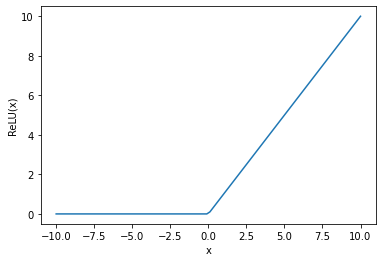

In [220]:
x = torch.linspace(-10, 10, 100)
y = torch.nn.functional.relu(x)
fig = plt.figure()
plt.plot(x,y)
plt.xlabel('x')
plt.ylabel('ReLU(x)')
plt.show()

In [37]:
class AlexNet(nn.Module):
    """
    AlexNet model architecture from the <https://arxiv.org/abs/1404.5997>`_ paper.
    Credits to https://github.com/Lornatang/AlexNet-PyTorch 
    """
    def __init__(self, num_classes=10, dropout_rate=0):
        # Notre modèle, comme tous les réseaux de neurones dans PyTorch,
        # hérite de la classe générique nn.Module.
        super(AlexNet, self).__init__()
        
        # A l'initialisation, on définit les couches du modèle, les fonctions
        # d'activation, etc. 

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        
        # On définit aussi les distributions de probabilité selon lesquelles
        # les paramètres du modèle vont être initialisés.

        for m in self.modules():
            # Les paramètres sont initialisés différemment 
            # selon le type de couche.
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
                
    def extract_features(self, inputs):
        """ Returns output of the final convolution layer """
        x = self.features(inputs)
        return x

    def forward(self, inputs):
        x = self.features(inputs)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [39]:
model = AlexNet()
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
   

model.named_parameters() renvoie un générateur de tuples contenant le nom et la valeur des paramètres d'une instance de nn.Module

In [40]:
[(x[0], x[1].shape) for x in model.named_parameters()]

[('features.0.weight', torch.Size([64, 3, 11, 11])),
 ('features.0.bias', torch.Size([64])),
 ('features.3.weight', torch.Size([192, 64, 5, 5])),
 ('features.3.bias', torch.Size([192])),
 ('features.6.weight', torch.Size([384, 192, 3, 3])),
 ('features.6.bias', torch.Size([384])),
 ('features.8.weight', torch.Size([256, 384, 3, 3])),
 ('features.8.bias', torch.Size([256])),
 ('features.10.weight', torch.Size([256, 256, 3, 3])),
 ('features.10.bias', torch.Size([256])),
 ('classifier.1.weight', torch.Size([4096, 9216])),
 ('classifier.1.bias', torch.Size([4096])),
 ('classifier.4.weight', torch.Size([4096, 4096])),
 ('classifier.4.bias', torch.Size([4096])),
 ('classifier.6.weight', torch.Size([10, 4096])),
 ('classifier.6.bias', torch.Size([10]))]

model.parameters() renvoie un générateur contenant uniquement la valeur des paramètres d'une instance de nn.Module

In [41]:
[param.shape for param in model.parameters()]

[torch.Size([64, 3, 11, 11]),
 torch.Size([64]),
 torch.Size([192, 64, 5, 5]),
 torch.Size([192]),
 torch.Size([384, 192, 3, 3]),
 torch.Size([384]),
 torch.Size([256, 384, 3, 3]),
 torch.Size([256]),
 torch.Size([256, 256, 3, 3]),
 torch.Size([256]),
 torch.Size([4096, 9216]),
 torch.Size([4096]),
 torch.Size([4096, 4096]),
 torch.Size([4096]),
 torch.Size([10, 4096]),
 torch.Size([10])]

Regardons plus en détails le fonctionnement d'une convolution 2D :

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html?highlight=conv#torch.nn.Conv2d

In [53]:
print(model.features[0].weight.shape)
print(model.features[0].bias.shape)
x = torch.ones((1, 3, 100, 100))
out = model.features[0](x)
print(out.shape)

torch.Size([64, 3, 11, 11])
torch.Size([64])
torch.Size([1, 64, 24, 24])


In [13]:
def n_params(model):
    n = 0
    for param in model.parameters():
        n += param.shape.numel()
    return n

print("{:.2e}".format(n_params(model)))

5.70e+07


### Charger des paramètres pré-entrainés

In [14]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
import math

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
pretrained_weights = torch.load('../pretrained_alex_net.pth.tar', 
                                map_location=device) # precise device on which the model is
model.load_state_dict(pretrained_weights['state_dict'])
del pretrained_weights # Delete the weights to clear memory

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


Observer les filtres de convolution peut nous donner un peu d'intuition sur le fonctionnement du modèle. On va regarder les filtres de la première couche de convolution pour le canal rouge.

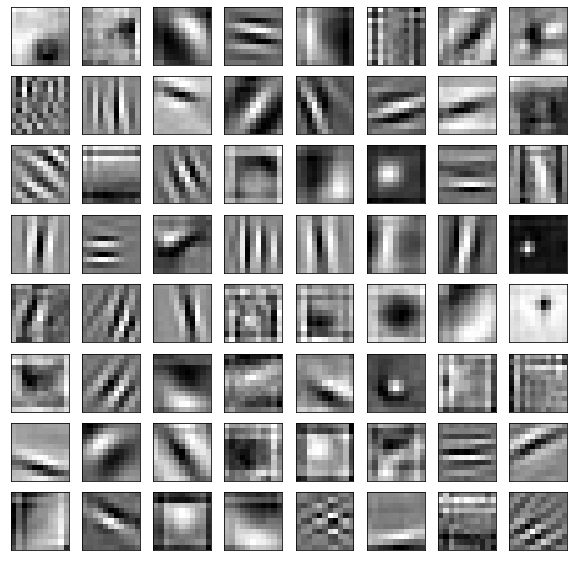

In [16]:
fig, ax = plt.subplots(8,8, figsize=(10,10))
k = 0
for i in range(8):
    for j in range(8):
        # A compléter 
        ax[i,j].imshow(....cpu(), cmap='gray')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        k += 1
plt.show()

### Chargement des données

On va s'intéresser à un extrait de l'image satellite RGB à haute résolution spatiale de Houston [2].

In [17]:
import rasterio
from rasterio.windows import Window
from rasterio.warp import reproject, Resampling
import numpy as np

On utilise ici la librairie rasterio pour recaler la vérité terrain (les annotations de pixels) avec l'image satellite, qui ne sont pas aux mêmes résolutions. 

In [18]:
with rasterio.open('../data/UH_NAD83_272056_3289689.tif') as img:
    window = Window(0, 0, 1000, 1000)
    data = img.read(window=window)
    
with rasterio.open('../data/2018_IEEE_GRSS_DFC_GT_TR.tif') as gt_:
    gt = np.zeros(img.shape, dtype=np.uint8)
    reproject(
        source=gt_.read(1),
        destination=gt,
        src_transform=gt_.transform,
        src_crs=gt_.crs,
        dst_transform=img.transform,
        dst_crs=img.crs,
        resampling=Resampling.nearest)
    
img = data.transpose(1, 2, 0)
gt = gt[:1000, :1000]
for i, class_id in enumerate(np.unique(gt)):
    gt[class_id == gt] = i

On va considérer dans la suite deux classes seulement : les bâtiments (classe 1) et la voirie (classe 2). Les pixels sans vérité terrain sont annotés par des zéros.

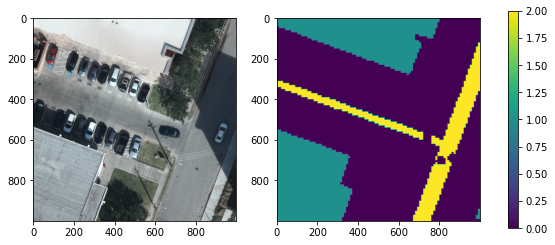

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(img)
ax1 = ax[1].imshow(gt)
fig.colorbar(ax1, ax=ax, shrink=0.4)
plt.show()

### Création du Dataset PyTorch


Pour optimiser un modèle PyTorch par descente de gradient stochastique par batchs, on utilise deux objets :

 - un torch.utils.data.Dataset pour parcourir les exemples d'apprentissage,
 - un torch.utils.data.DataLoader pour faire des batchs d'exemples.
 
On souhaiterait donner en entrée du modèle AlexNet des imagettes de 125 x 125 pixels, pour obtenir en sortie la prédiction de la classe du pixel au centre de l'imagette. 

Pour cela, on va construire notre propre torch.utils.data.Dataset : 
https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset

Remarque : le but ici est pédagogique, on utiliserait des architectures de réseaux plus adaptées en réalité.

In [20]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, gt, hyperparams):
        """
        Args:
            data: 3D hyperspectral image
            gt: 2D array of labels
            patch_size: int, size of the spatial neighbourhood
            ignored_labels: list of ints, labels to ignore

        """
        super(Dataset, self).__init__()
        self.data = data
        self.label = gt
        self.patch_size = hyperparams["patch_size"]
        self.ignored_labels = set(hyperparams["ignored_labels"])        
        self.height = data.shape[0]
        self.width = data.shape[1]

        mask = np.ones_like(gt)
        for l in self.ignored_labels:
            mask[gt == l] = 0

        x_pos, y_pos = np.nonzero(mask)
        p = self.patch_size // 2
        if p > 0:
            self.indices = np.array(
                [
                    (x, y)
                    for x, y in zip(x_pos, y_pos)
                    if x >= p and x < data.shape[0] - p and y >= p and y < data.shape[1] - p
                ]
            )
        else:
            self.indices = np.array(
                [
                    (x, y)
                    for x, y in zip(x_pos, y_pos)
                ]
            )
            
        self.labels = [self.label[x, y] for x, y in self.indices]

    def __len__(self):
        # A compléter 
        ... 

    def __getitem__(self, i):
        # A compléter
        x, y = ... 
        x1, y1 = x - self.patch_size // 2, y - self.patch_size // 2
        x2, y2 = x1 + self.patch_size, y1 + self.patch_size
        
        # A compléter
        data = ...
        label = ...

        # Copie de data et label dans des npy array
        data = np.asarray(np.copy(data).transpose((2, 0, 1)), dtype="float32")
        label = np.asarray(np.copy(label), dtype="int64")

        # Conversion des npy array en torch.tensor
        # A compléter
        data = ...
        label = ...

        return data, label

On partitionne les données en un jeu d'apprentissage et un jeu de validation.

In [206]:
hyperparams = {'ignored_labels': [0], 'patch_size': 125}
dataset = Dataset(img, gt, hyperparams)

# A compléter
train_dataset, val_dataset = ... # On souhaite couper le dataset en un set d'apprentissage et un set de validation

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False)

On peut visualiser un exemple comme suit :

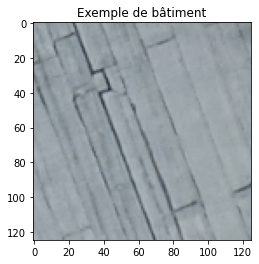

In [207]:
for patch, label in train_loader:
    break
fig = plt.figure()
plt.imshow(patch[30,:,:,:].transpose(2,0)/256)

if label[30].item() == 1:
    plt.title('Exemple de bâtiment')
elif label[30].item() == 2:
    plt.title('Exemple de voirie')
else:
    plt.title('Exemple autre')
plt.show()

### Fine-tuning d'un modèle pré-entrainé

On souhaiterait adapter le modèle AlexNet à nos données. En effet, le nombre de paramètres d'AlexNet est bien trop grand par rapport au nombre de pixels annotés sur notre image. Dans la suite, on conserve uniquement la première couche de convolution d'origine d'AlexNet.

In [208]:
class TinyAlexNet(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0):
        super(TinyAlexNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 1, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(36, 16),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(16, num_classes)
        )
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
                
    def extract_features(self, inputs):
        """ Returns output of the final convolution layer """
        x = self.features(inputs)
        return x

    def forward(self, inputs):
        x = self.features(inputs)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [209]:
model = TinyAlexNet(num_classes=2)

On charge les paramètres d'AlexNet optimisés sur ImageNet.

In [210]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
model = model.to(device) # On charge le modèle sur GPU si elle est disponible
pretrained_weights = torch.load('../pretrained_alex_net.pth.tar', 
                                map_location=device) # on précise le "device" sur lequel est le modèle
pretrained_weights['state_dict'].keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.3.weight', 'features.3.bias', 'features.6.weight', 'features.6.bias', 'features.8.weight', 'features.8.bias', 'features.10.weight', 'features.10.bias', 'classifier.1.weight', 'classifier.1.bias', 'classifier.4.weight', 'classifier.4.bias', 'classifier.6.weight', 'classifier.6.bias'])

On conserve les paramètres de la première couche de convolution, que l'on fige pour l'optimisation.

In [211]:
model.features[0].weight.data = ...
model.features[0].bias.data = ...
del pretrained_weights # On supprime les poids de la mémoire du GPU

In [212]:
model.features[0].weight.requires_grad

True

In [213]:
# A compléter
... 

print(model.features[0].weight.requires_grad, model.features[0].bias.requires_grad)

False False


Regardons les dimensions de "l'image" au fil des convolutions.

In [214]:
x = torch.ones((1, 3, 125, 125))
out = model.features[0](x)
print(out.shape)
out = model.features[2](out)
print(out.shape)
out = model.features[3](out)
print(out.shape)
out = model.features[5](out)
print(out.shape)

torch.Size([1, 64, 30, 30])
torch.Size([1, 64, 14, 14])
torch.Size([1, 1, 14, 14])
torch.Size([1, 1, 6, 6])


On définit la technique d'optimisation et ses hyper-paramètres.

In [215]:
num_epochs = 1
learning_rate = 1e-4
best_val = np.inf
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [217]:
from tqdm import tqdm 
from sklearn.metrics import accuracy_score, f1_score

for epoch in range(num_epochs):
    y_pred, y_true = [], []
    for patch, label in tqdm(train_loader):
        # A compléter
        ...
        
        y_pred.extend(torch.argmax(logits, dim=-1).cpu())
        y_true.extend(label.cpu())
          
    train_accuracy = accuracy_score(y_pred, y_true)
    train_f1 = f1_score(y_pred, y_true)
    
    print('[Train] \t Loss: {:.4f} | Accuracy: {:.4f} | F1 score: {:.4f}'.format(\
                                            loss.item(), train_accuracy, train_f1))
    
    y_pred, y_true = [], []
    for patch, label in tqdm(val_loader):
        # A compléter 
        ...
        
        y_pred.extend(torch.argmax(logits, dim=-1).cpu())
        y_true.extend(label.cpu())
        
    val_accuracy = accuracy_score(y_pred, y_true)
    val_f1 = f1_score(y_pred, y_true)
    
    if val_loss.item() < best_val:
        best_val = val_loss.item()
        torch.save({'epoch': epoch, 
                    'best_loss': best_val, 
                    'state_dict': model.state_dict()}, 'best_model.pth.tar')
        
    
    print('[Val] \t Loss: {:.4f} | Accuracy: {:.4f} | F1 score: {:.4f}'.format(\
                                          val_loss.item(), val_accuracy, val_f1))

100%|██████████| 740/740 [01:54<00:00,  6.48it/s]


[Train] 	 Loss: 0.0156 | Accuracy: 0.9756 | F1 score: 0.9593


100%|██████████| 185/185 [00:27<00:00,  6.84it/s]


[Val] 	 Loss: 0.0216 | Accuracy: 0.9924 | F1 score: 0.9876
